In [34]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [36]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
#from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config
config = get_config()
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

Using CPU



In [37]:
rmses = {}
for Nepoch in config.max_epochs:
    if "PMS" in config.scoreNet_trained_path:
        model_type = "PMS"
    elif "PM" in config.scoreNet_trained_path:
        model_type = "PM"
    else:
        model_type = ""
    if "fQuadSinHF" in config.data_path:
        file_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
                    ".", "")
    elif "fBiPot" in config.data_path:
        file_path = (
                project_config.ROOT_DIR + f"experiments/results/TS{model_type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac_").replace(
            ".", "")
    print(f"LFac:{config.loss_factor}")
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
        Xshape = muhats.shape[0]
        if "fQuadSinHF" in config.data_path:
            if config.deltaT > 1/(32*256):
                Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
            else:
                Xs = torch.linspace(-.4, .4, steps=Xshape)
            ts_type = "fQuadSinHF"
        elif "fBiPot" in config.data_path:
            Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
            ts_type="fBiPot"
        if model_type == "":
            model_type="Standard"
        assert (config.max_diff_steps == 10000)
        if "fQuadSin" in config.data_path:
            true_drifts = (-2.*config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs)).numpy()
        elif "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        rmses.update({Nepoch: round(rmse, 4)})
    except FileNotFoundError as e:
        print(e)
        continue
rmses

LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2
LFac:2


{60: 0.2953,
 100: 0.2553,
 150: 0.3429,
 300: 0.054,
 960: 0.0871,
 1440: 0.1002,
 1920: 0.0624,
 2920: 0.0939,
 6920: 0.1034,
 7190: 0.0668,
 8190: 0.104,
 12920: 0.0982}

0.003787000376519899


0.9748674651247401

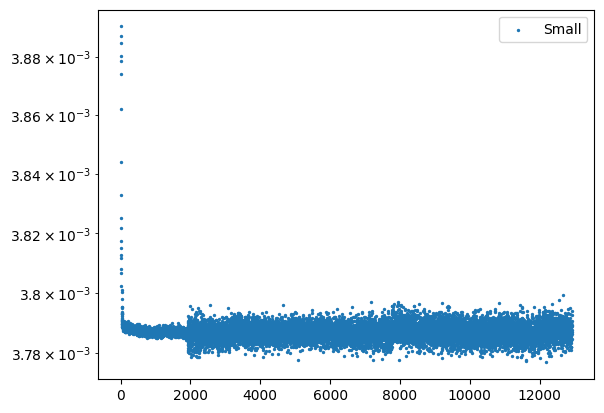

In [10]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f))#/config.deltaT
start_idx = 10
plt.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:],s=2, label="Small")
print(np.mean(losses[400:]))
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses[-1]/losses[start_idx]

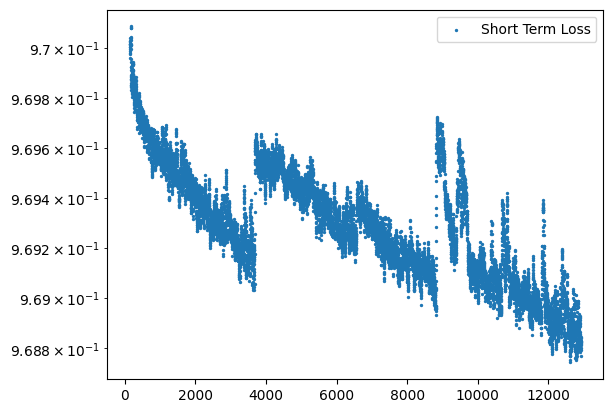

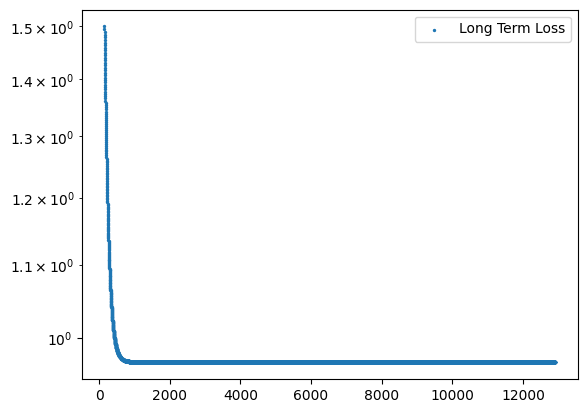

In [139]:
start_idx = 150
end_idx = losses.shape[0]
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9  # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, end_idx), (short_term_ema[start_idx:end_idx+1]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, end_idx), (long_term_ema[start_idx:end_idx+1]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [140]:
from src.generative_modelling.data_processing import prepare_recursive_scoreModel_data
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Hook function to capture activations
def hook_fn_lstm(feature_history,module, input, output):
    # Store the output activations (hidden states)
    # TODO: This is only valid for RNN feature vectors
    output = output[0][:, :-1, :]
    B, T = output.shape[0], output.shape[1]
    output = output.reshape(B * T, 1, -1)
    feature_history.append(output.detach().cpu().numpy())

# Hook function to capture activations
def hook_fn_projection(feature_history,module, input, output):
    # Store the output activations (hidden states)
    feature_history.append(output.detach().cpu().numpy())

# Assuming you have a function that can load the model at a given epoch
def load_model_at_epoch(config, Nepoch):
    # Fix the number of training epochs and training loss objective loss
    model = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters).to(device)
    model.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))
    return model


def create_historical_vectors(model, init_state, device, batch):
        """
        Create history vectors using LSTM architecture
            :return: History vectors for each timestamp
        """
        # dbatch = torch.cat([torch.zeros((batch.shape[0], 1, batch.shape[-1])).to(batch.device), batch], dim=1)
        # batch shape (N_batches, Time Series Length, Input Size)
        # hidden states: (D*NumLayers, N, Hidden Dims), D is 2 if bidirectional, else 1.
        init_state = init_state.to(batch.device).view(1, 1, batch.shape[-1])  # Reshape to (1, 1, D)
        init_state = init_state.expand(batch.shape[0], -1, -1)  # Expand to (B, 1, D)
        dbatch = torch.cat([init_state, batch], dim=1)
        dbatch = dbatch.cumsum(dim=1)
        if type(device) == int:
            output, (hn, cn) = (model.module.rnn(dbatch, None))
        else:
            output, (hn, cn) = (model.rnn(dbatch, None))
        return output[:, :-1, :]


def extract_features(model, diffusion, init_state,data_loader, device):
    """Extract features from the model during evaluation"""
    model.eval()
    with torch.no_grad():
        timesteps = torch.linspace(config.train_eps, end=config.end_diff_time, steps=config.max_diff_steps)
        for x0s in (iter(data_loader)):
            x0s = x0s[0].to(device)

            # Generate history vector for each time t for a sample in (batch_id, t, numdims)
            features = create_historical_vectors(model=model, init_state=init_state, device=device, batch=x0s)
            diff_times = timesteps[torch.randint(low=0, high=config.max_diff_steps, dtype=torch.int32,
                                                 size=x0s.shape[0:2]).long()].view(x0s.shape[0], x0s.shape[1],
                                                                                   *([1] * len(x0s.shape[2:]))).to(device)
            # Diffusion times shape (Batch Size, Time Series Sequence, 1)
            # so that each (b, t, 1) entry corresponds to the diffusion time for timeseries "b" at time "t"
            eff_times = diffusion.get_eff_times(diff_times)
            # Each eff time entry corresponds to the effective diffusion time for timeseries "b" at time "t"
            xts, target_scores = diffusion.noising_process(x0s, eff_times)
            B, T, D = xts.shape
            xts = xts.reshape(B * T, 1, -1)
            features = features.reshape(B * T, 1, -1)
            target_scores = target_scores.reshape(B * T, 1, -1)
            diff_times = diff_times.reshape(B * T)
            eff_times = torch.cat([eff_times]*D, dim=2).reshape(target_scores.shape)
            model.forward(inputs=xts, conditioner=features, times=diff_times, eff_times=eff_times)
    return None

def per_model_features(model, hook_fn, hook_fn_choice, feature_history, data_loader, device, diffusion, init_state):
        features_per_epoch = []
        # Register hook to capture activations from the RNN layer (e.g., 'self.rnn')
        hooked_fn = partial(hook_fn[min(hook_fn_choice, 1)], features_per_epoch)
        # Load model at the current epoch
        # Choose the "MODULE" from print(model_at_epoch) here (in this case RNN)
        if hook_fn_choice == 0:
            hook = model.rnn.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 1:
            hook = model.input_projection.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 2:
            hook = model.diffusion_embedding.projection1.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 3:
            hook = model.diffusion_embedding.projection2.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 4:
            hook = model.cond_upsampler.linear1.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 5:
            hook = model.skip_projection.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 6:
            hook = model.residual_layers[0].dilated_conv.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 7:
            hook = model.residual_layers[0].conditioner_projection.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 8:
            hook = model.residual_layers[0].diffusion_projection.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 9:
            hook = model.residual_layers[0].output_projection.register_forward_hook(hooked_fn)
        # Extract features from the model at this epoch
        extract_features(model=model, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)
        hook.remove()
        feature_history.append(np.concatenate(features_per_epoch, axis=0)[np.newaxis,:])
def plot_feature_evolution(feature_history, epochs, rmses,ts_type:str,feature_name:str, method='TSNE', perplexity=50):
    """Plot feature evolution using t-SNE or PCA"""
    #assert (feature_history.shape == (len(epochs), training_size*config.ts_length, 1, config.lstm_hiddendim))
    red_features = []
    for i in range(feature_history.shape[0]):
        features_per_epoch = feature_history[i, :, :, :]
        features_per_epoch = np.squeeze(features_per_epoch)
        print(features_per_epoch.shape)
        #assert (features_per_epoch.shape == (training_size*config.ts_length, config.lstm_hiddendim))
        if method == 'TSNE':
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            features_reduced = tsne.fit_transform(features_per_epoch)
        elif method == 'PCA':
            pca = PCA(n_components=2)
            features_reduced = pca.fit_transform(features_per_epoch)
        else:
            raise ValueError("Method should be 'TSNE' or 'PCA'")
        red_features.append(features_reduced)
    # Plot the features
    fig, ax = plt.subplots(figsize=(14,9))
    from matplotlib import colors
    norm = plt.Normalize(vmin=min(rmses.values()), vmax=max(rmses.values()))
    cmap = plt.cm.viridis  # You can use other colormaps like 'coolwarm', 'plasma', etc.
    for i in range(len(red_features)):
        rmse_value = rmses[epochs[i]]  # Get the RMSE for the current epoch
        color = cmap(norm(rmse_value))  # Normalize and map RMSE value to color
        ax.scatter(red_features[i][:, 0], red_features[i][:, 1], label=f"Epoch {epochs[i]}", color=color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array to avoid warnings
    cbar = plt.colorbar(sm, ax=ax,label="RMSE")
    # Set colorbar label and font size
    cbar.set_label("RMSE", fontsize=38)
    # Set colorbar tick label size
    cbar.ax.tick_params(labelsize=24)

    plt.legend(fontsize=24)
    plt.tick_params(labelsize=24)
    plt.xlabel("PC 1", fontsize=38)
    plt.ylabel("PC 2", fontsize=38)
    plt.title(f"{method} of {feature_name}", fontsize=40)
    plt.tight_layout()
    #plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}_LSTM_{feature_name}PCAProj_{config.deltaT:.3e}dT_{config.loss_factor}LFac.png",  bbox_inches='tight')
    plt.show()
    plt.close()

In [141]:
import pyperclip
epoch = 150
model_at_epoch = load_model_at_epoch(Nepoch=epoch, config=config)
#for name, layer in model_at_epoch.named_modules():
    #print(f"Layer Name: {name}, Layer Type: {type(layer)}")
pyperclip.copy(str(model_at_epoch))
print(model_at_epoch)

ConditionalLSTMTSPostMeanScoreMatching(
  (rnn): LSTM(1, 20, batch_first=True)
  (input_projection): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (diffusion_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=128, out_features=64, bias=True)
    (projection2): Linear(in_features=64, out_features=64, bias=True)
  )
  (cond_upsampler): CondUpsampler(
    (linear1): Linear(in_features=20, out_features=2, bias=False)
    (linear2): Linear(in_features=2, out_features=1, bias=False)
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conditioner_projection): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
      (diffusion_projection): Linear(in_features=64, out_features=8, bias=True)
      (output_projection): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
  )
  (skip_projection): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (output_projection): Conv1d(8, 1, kernel_size=(1,),

In [142]:
from functools import partial

training_size = int(config.batch_size)
data = np.load(config.data_path, allow_pickle=True)
data = np.concatenate([data[:, [0]]-config.initState, np.diff(data, axis=1)], axis=1)
data = np.atleast_3d(data[:training_size, :])
assert (data.shape == (training_size, config.ts_length, config.ts_dims))
data_loader = prepare_recursive_scoreModel_data(data=data, batch_size=config.batch_size, config=config)

# Example usage for multiple epochs
epochs = np.array(list(rmses.keys()))[np.argsort(list(rmses.values()))][[0,1, -2, -1]]
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
if isinstance(config.initState, float):
    init_state = torch.Tensor([config.initState])
else:
    init_state = torch.Tensor(config.initState)
hook_fn = [hook_fn_lstm, hook_fn_projection]
feature_names = ["LSTM", "InputProj", "DiffEmb_Proj1", "DiffEmb_Proj2", "ConUpSamp", "SkipProj", "ResLay0_Conv","ResLay0_CondProj", "ResLay0_DiffProj","ResLay0_OutputProj"]

Total Number of Datapoints 256 :: DataLoader Total Number of Datapoints 256


(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)


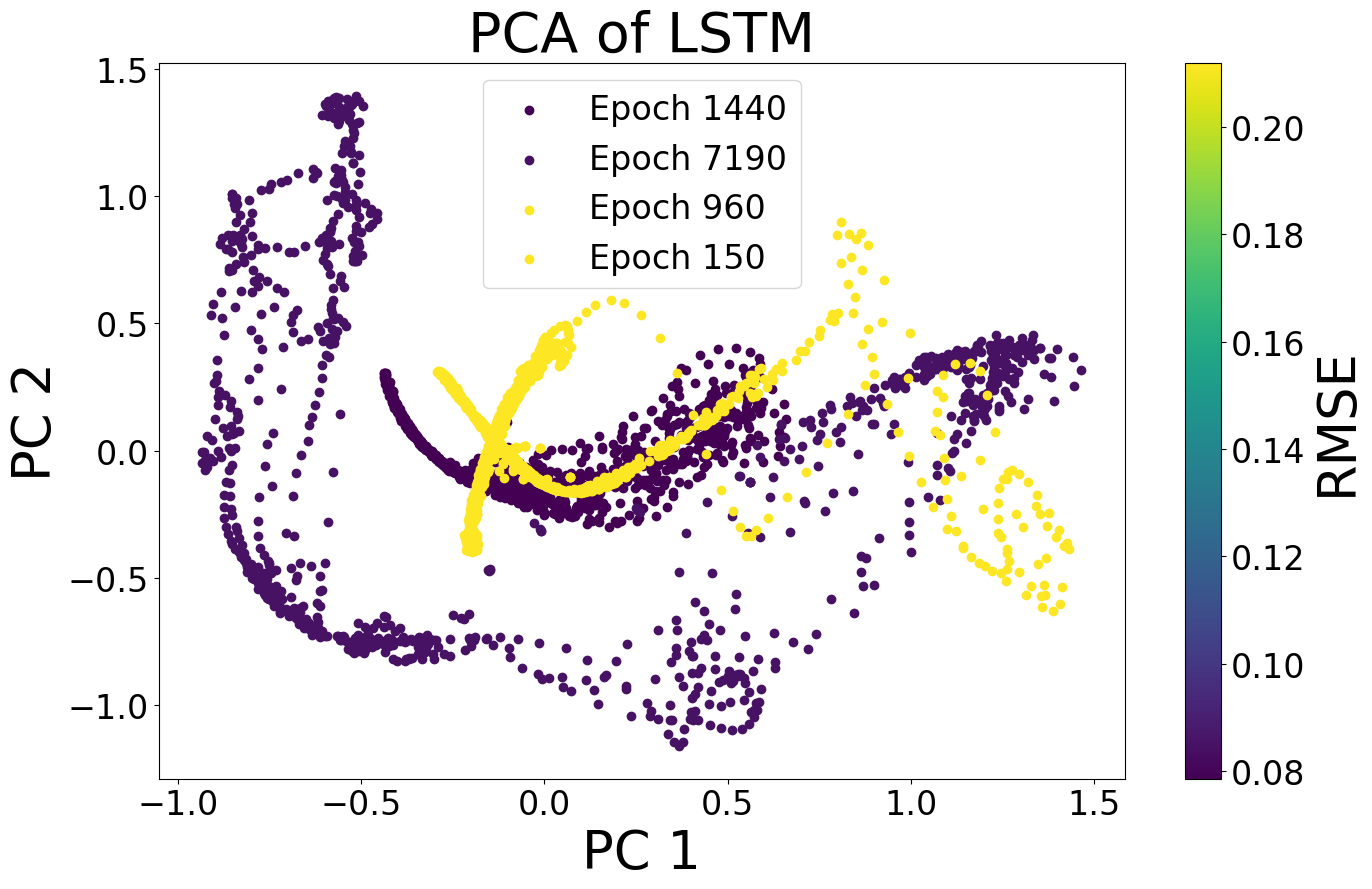

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


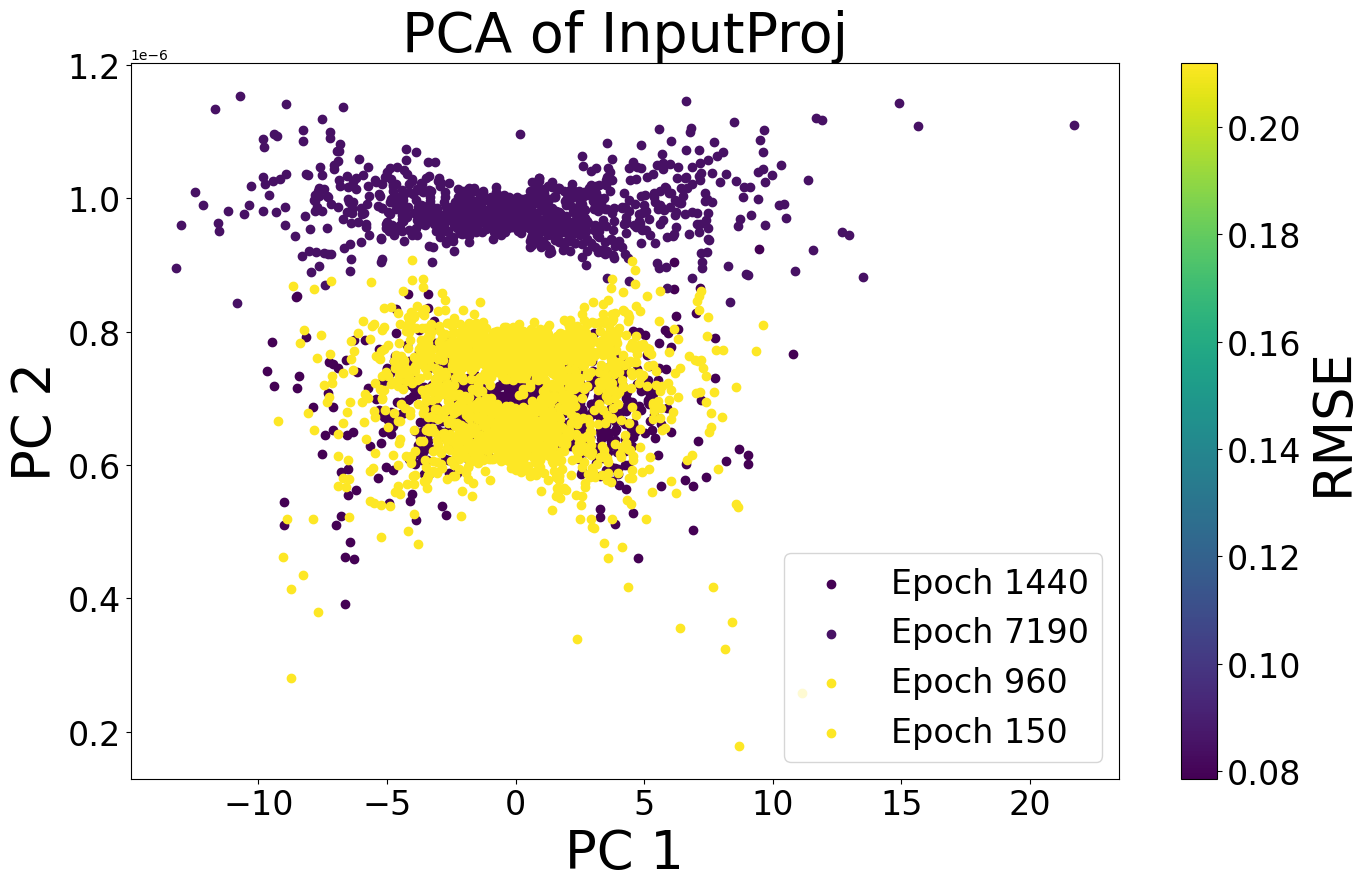

(1000, 64)
(1000, 64)
(1000, 64)
(1000, 64)


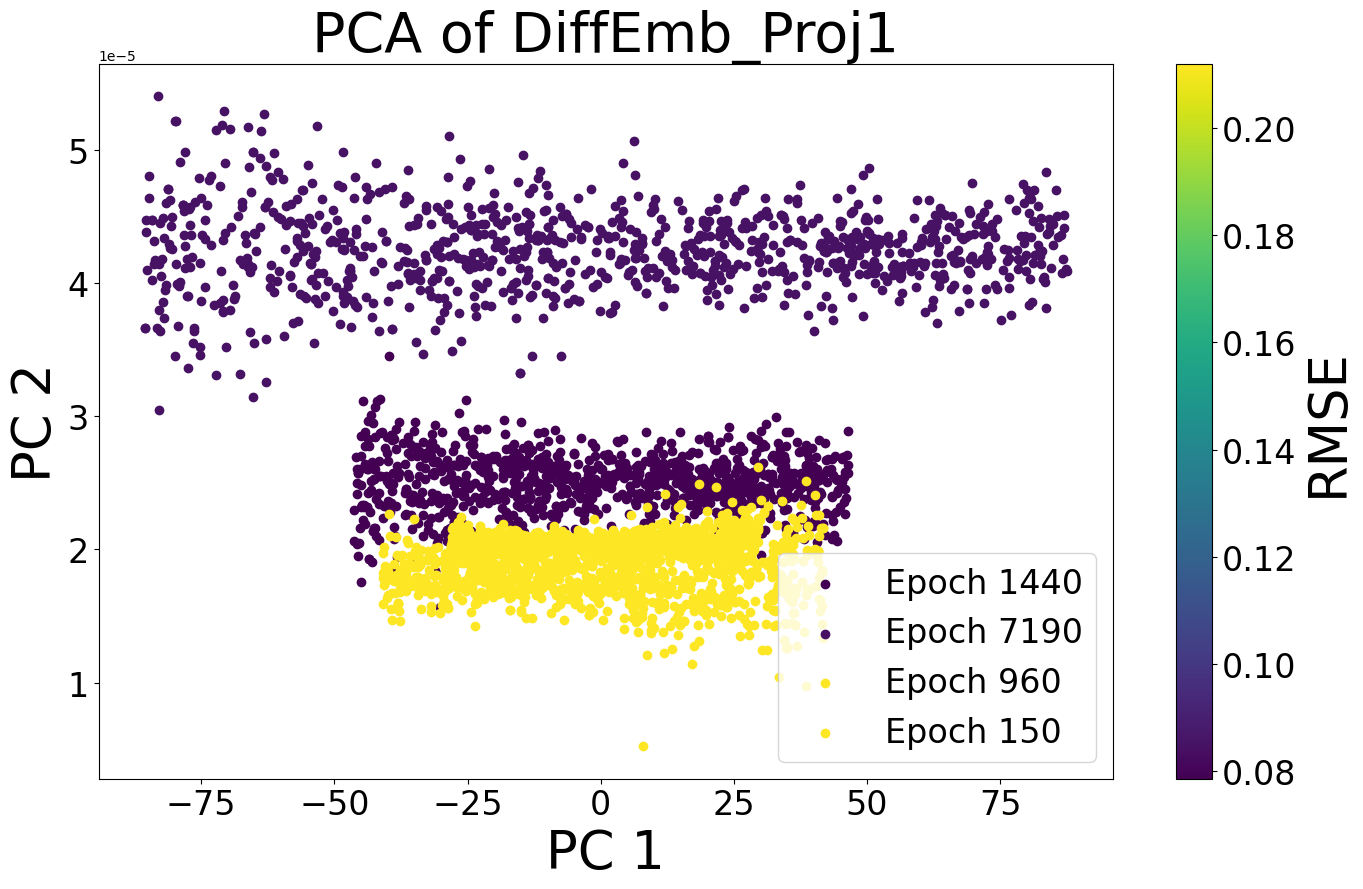

(1000, 64)
(1000, 64)
(1000, 64)
(1000, 64)


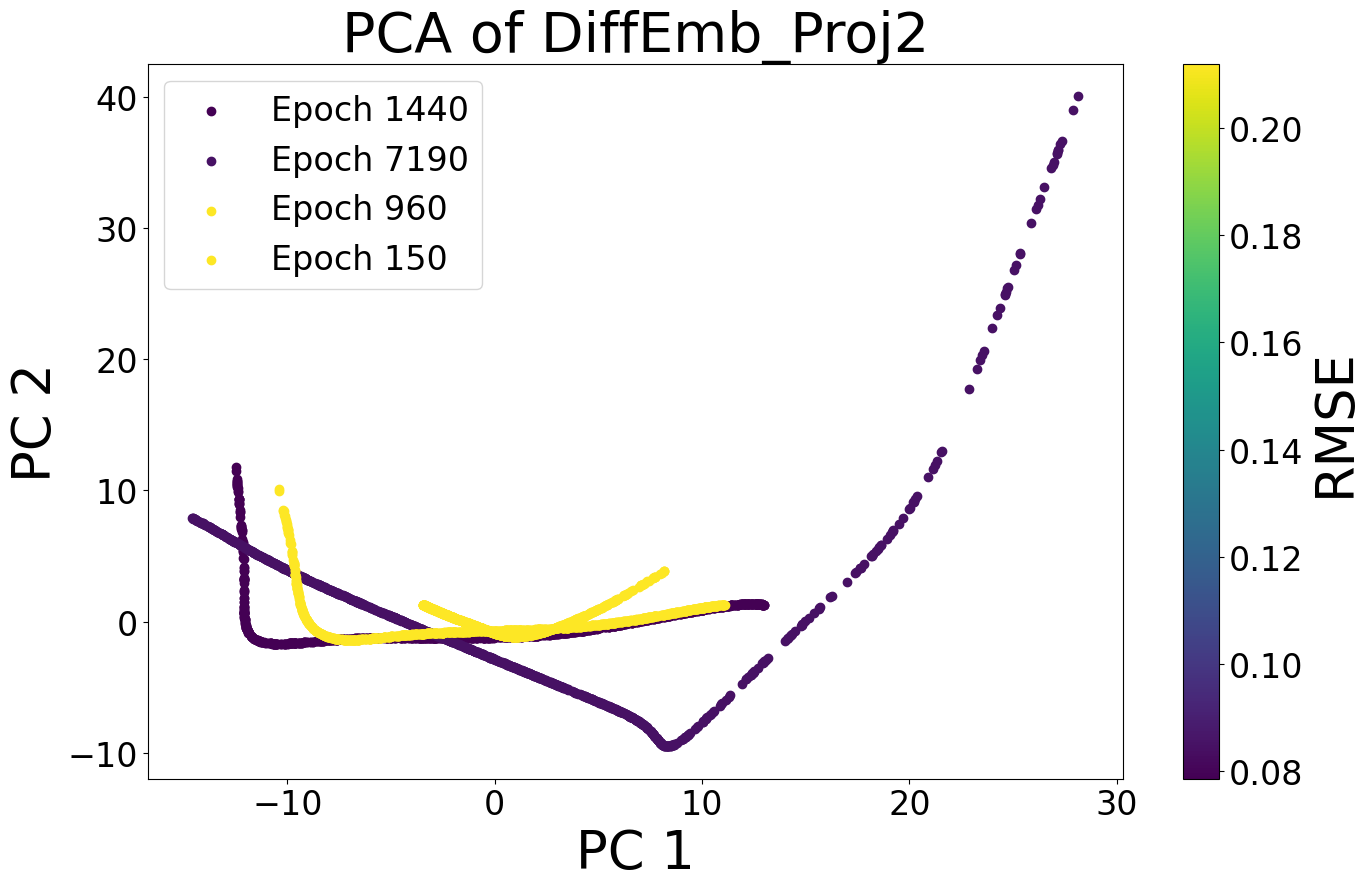

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


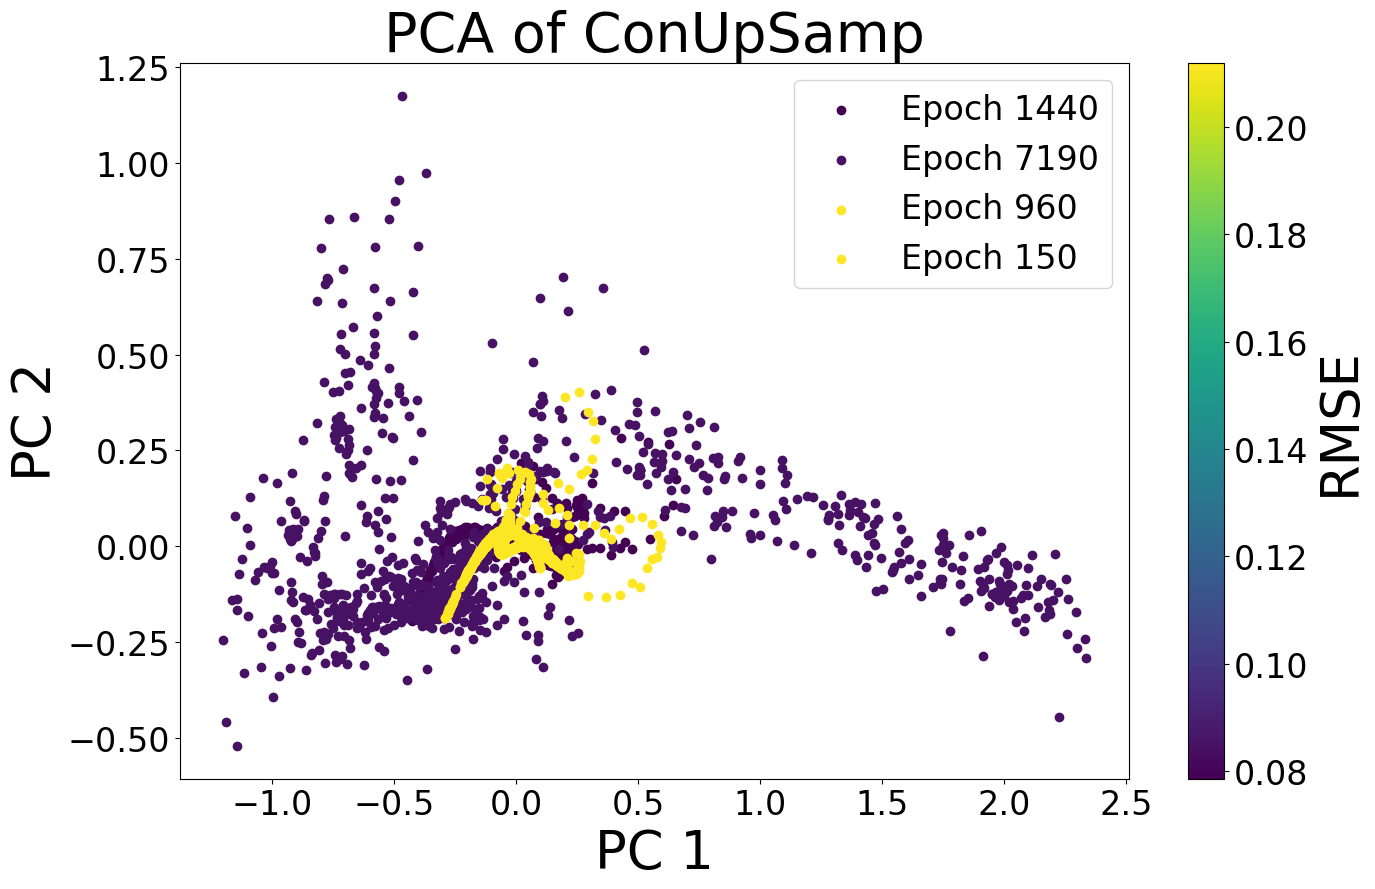

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


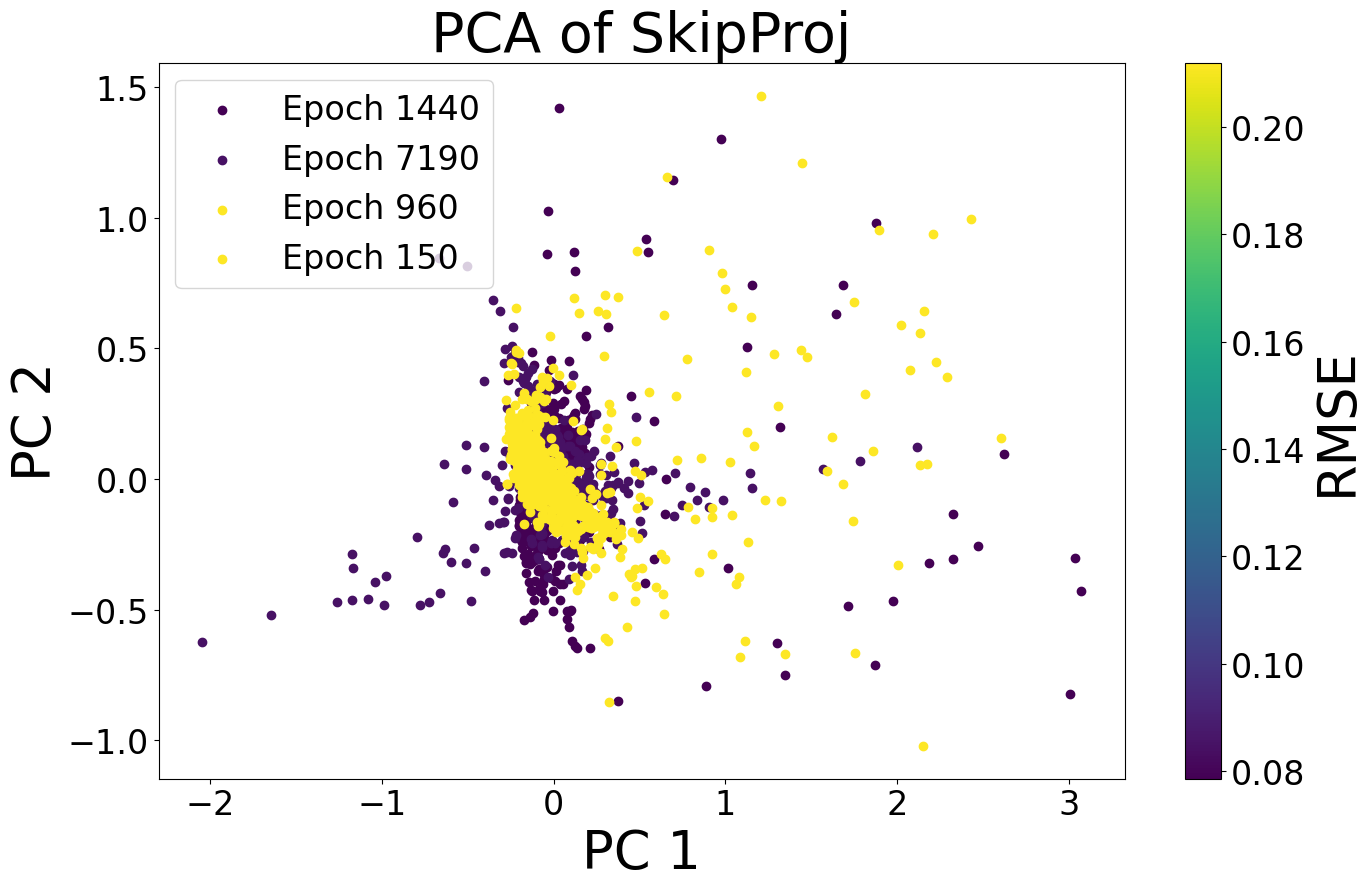

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


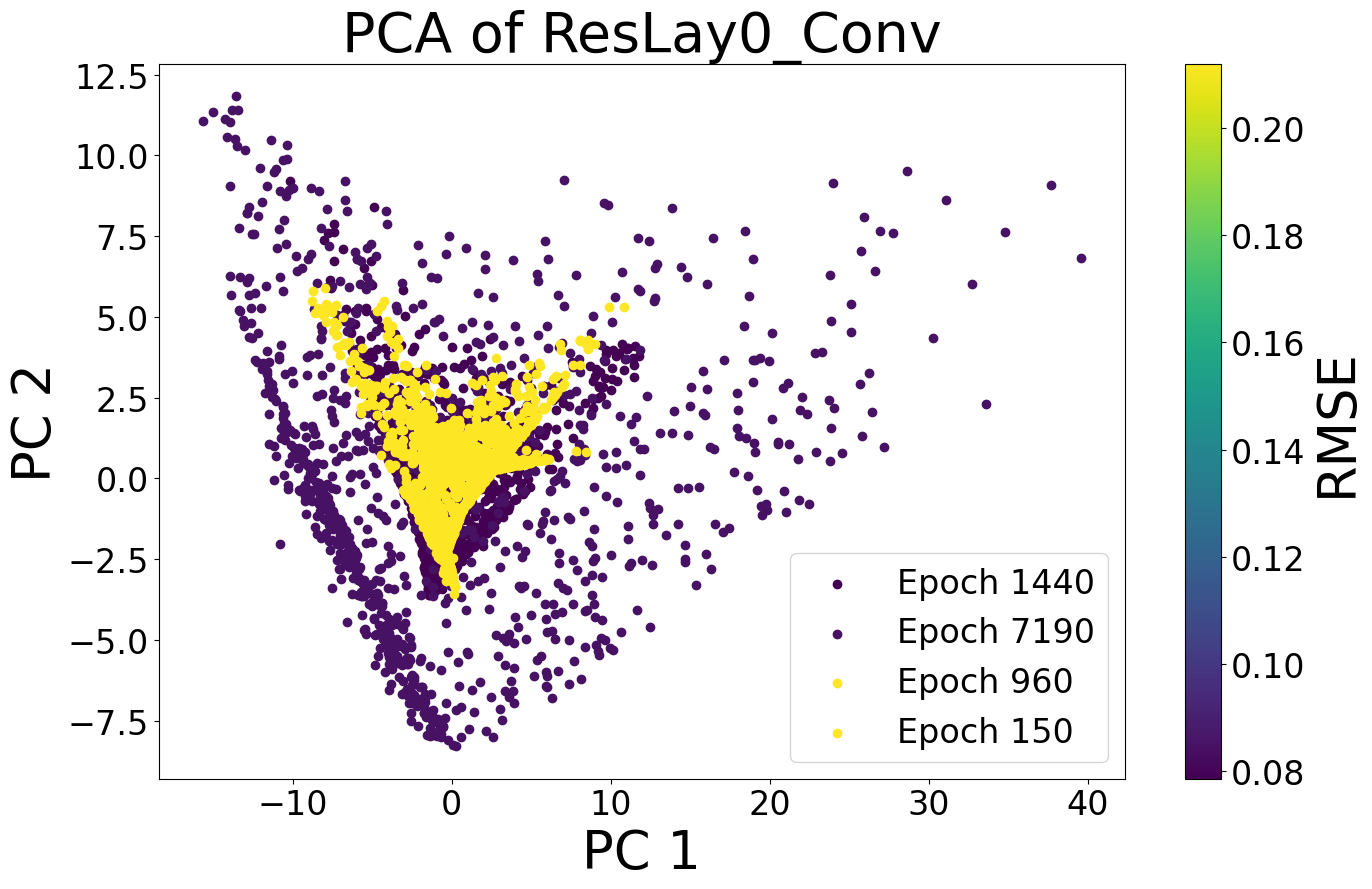

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


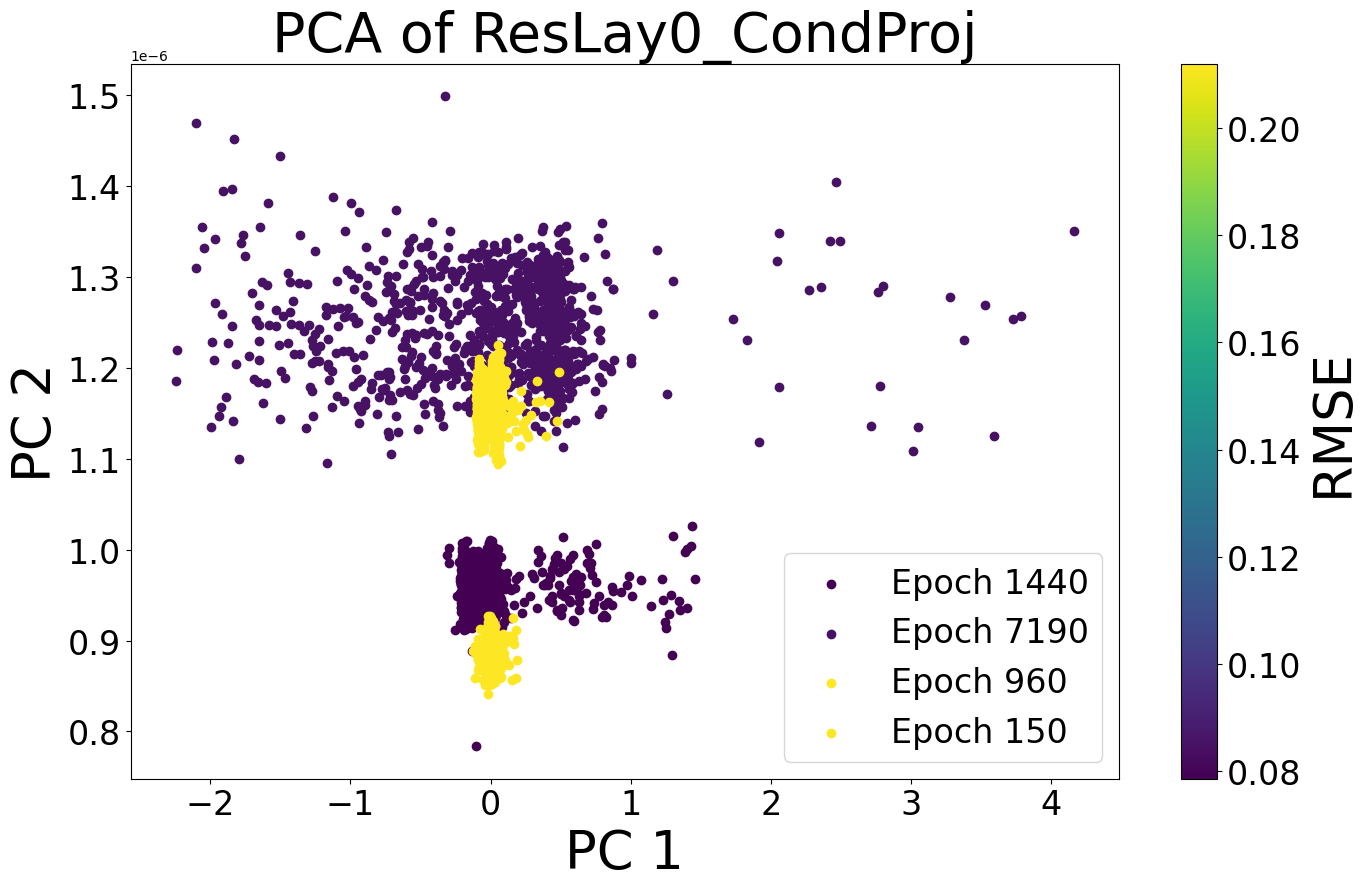

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


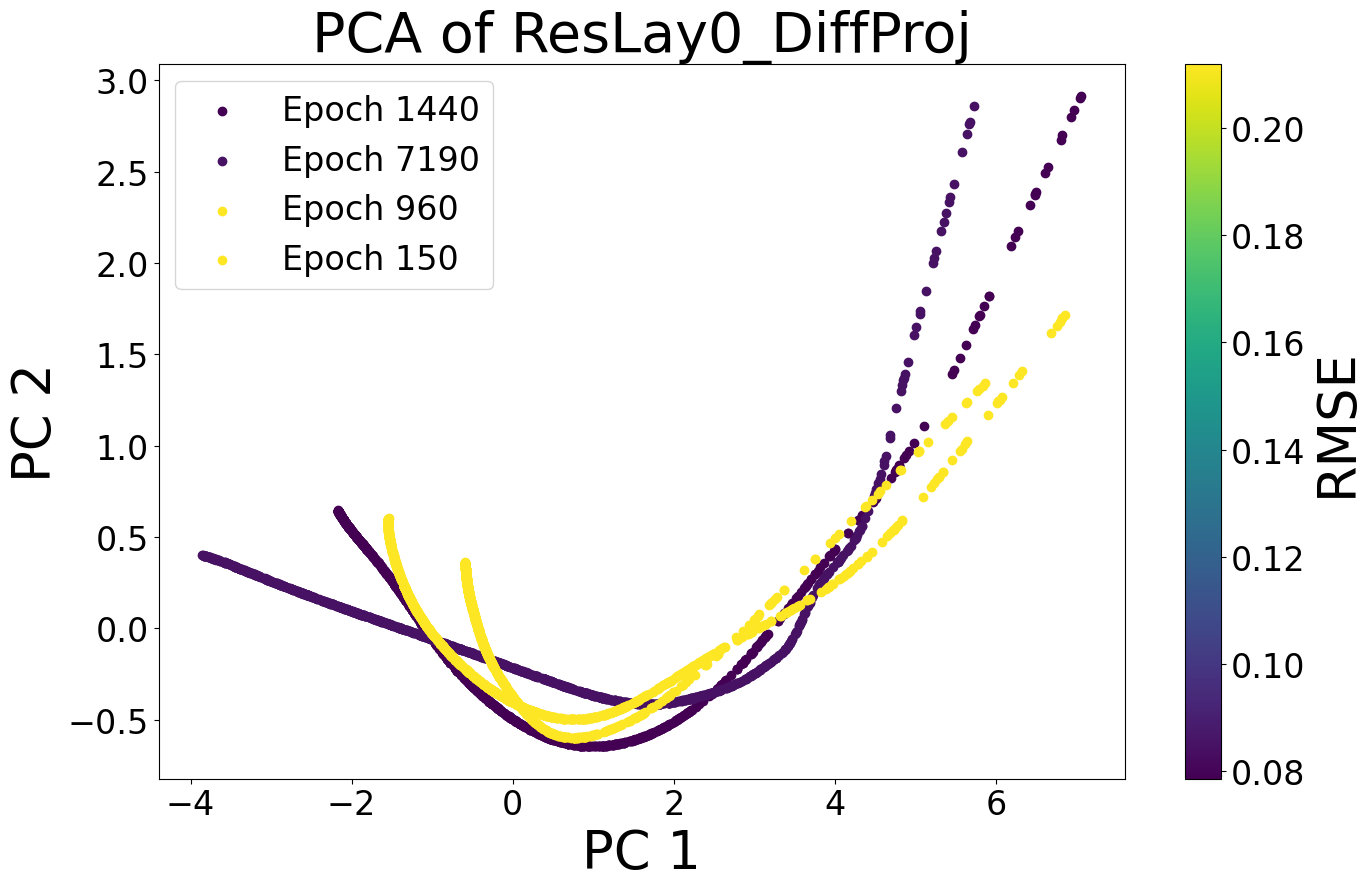

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


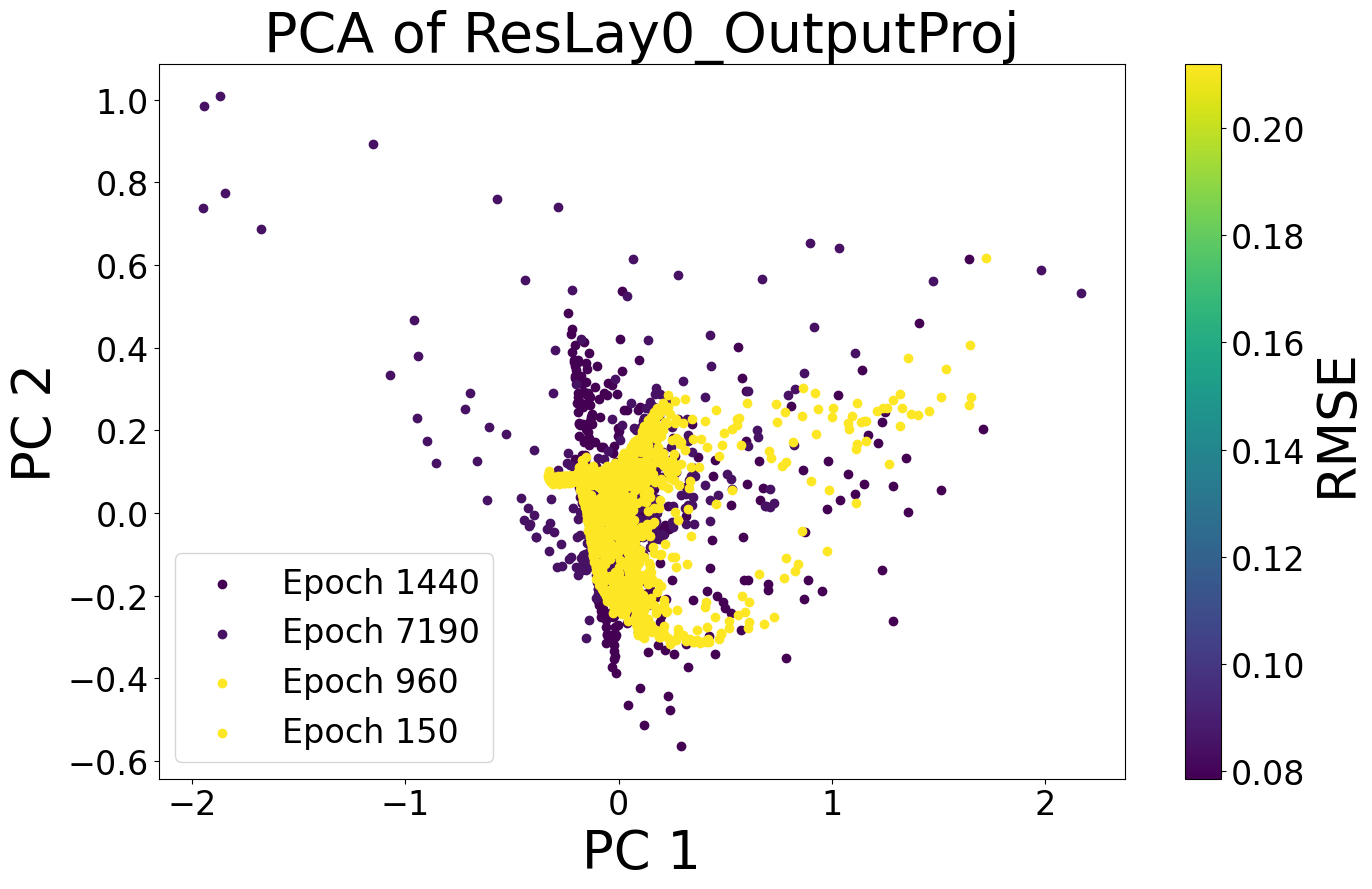

In [143]:
for hook_fn_choice in range(10):
    # Store features over different epochs
    feature_history = []
    # Iterate over the models saved at specific epochs
    for epoch in epochs:
        model_at_epoch = load_model_at_epoch(Nepoch=epoch, config=config)
        per_model_features(model=model_at_epoch, hook_fn=hook_fn, hook_fn_choice=hook_fn_choice, feature_history=feature_history, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)
    # Combine features and labels across all epochs
    feature_history = np.concatenate(feature_history, axis=0)
    if len(feature_history.shape) < 4:
        feature_history = feature_history[:, :, np.newaxis, :]
    plot_feature_evolution(feature_history=feature_history[:,:1000,:,:], epochs=epochs, rmses={k: v for k, v in rmses.items() if k in epochs},method="PCA", feature_name=feature_names[hook_fn_choice],ts_type=ts_type)

(1000, 20)
(1000, 20)
(1000, 20)
(1000, 20)


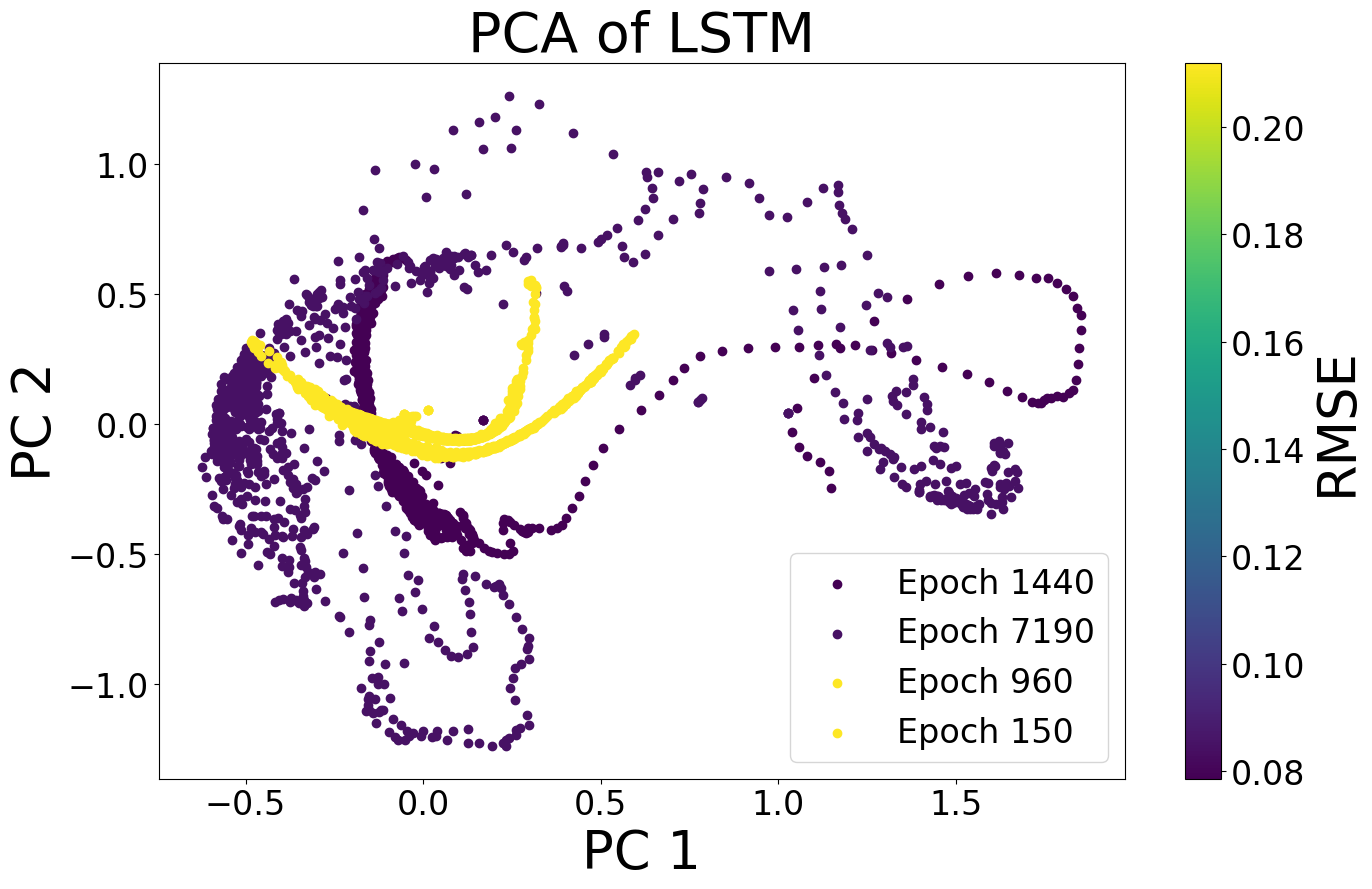

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


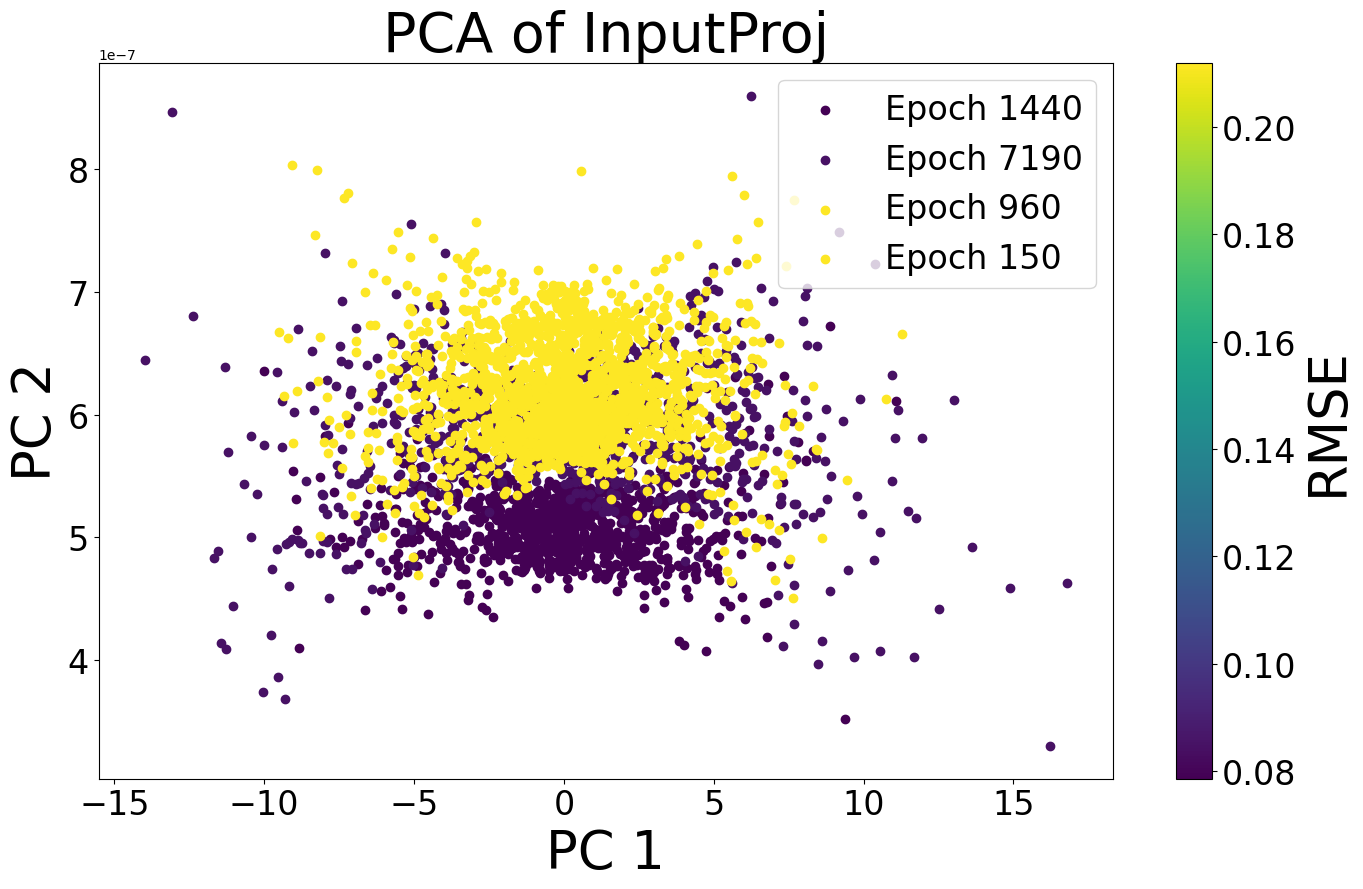

(1000, 64)
(1000, 64)
(1000, 64)
(1000, 64)


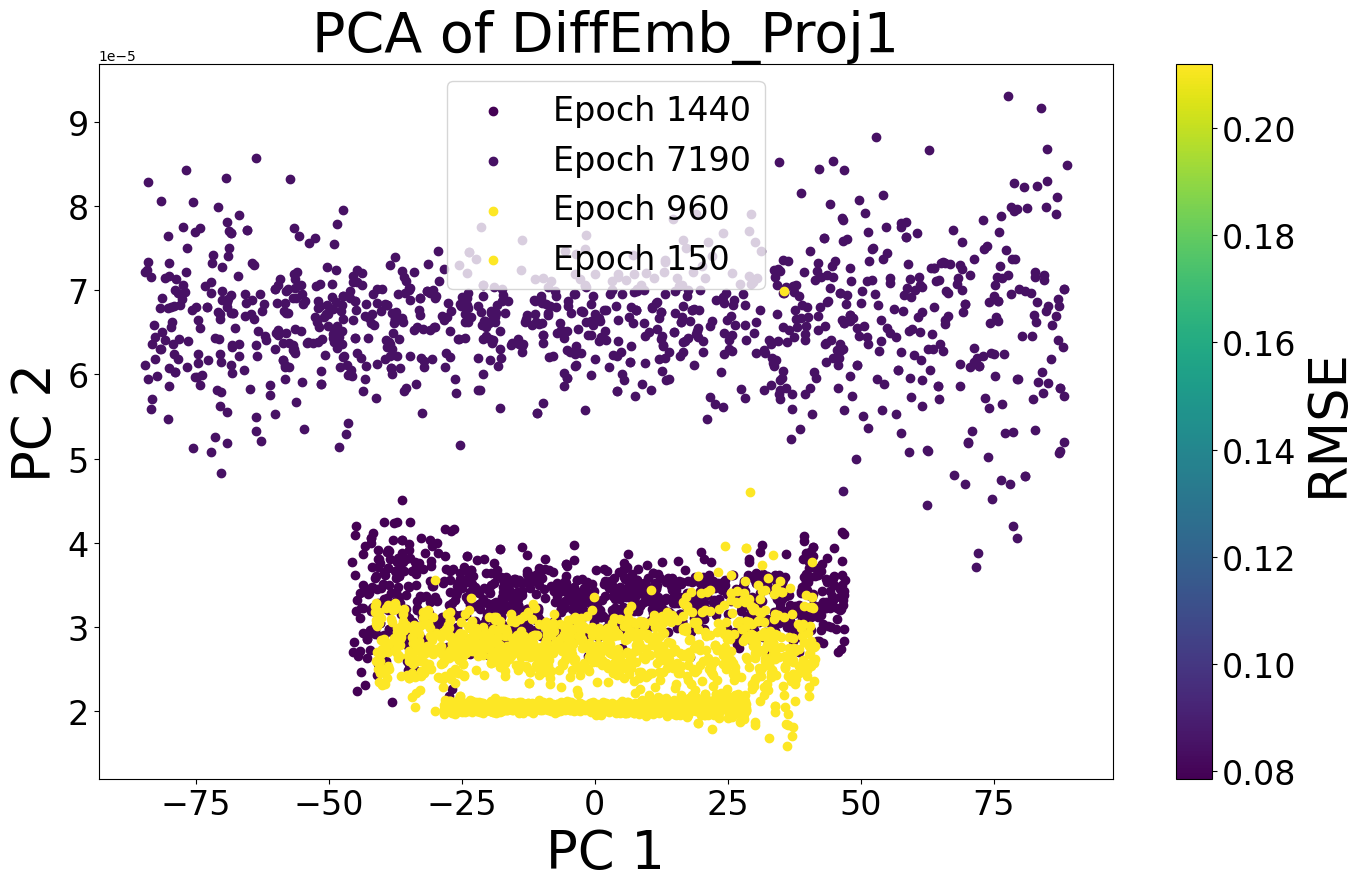

(1000, 64)
(1000, 64)
(1000, 64)
(1000, 64)


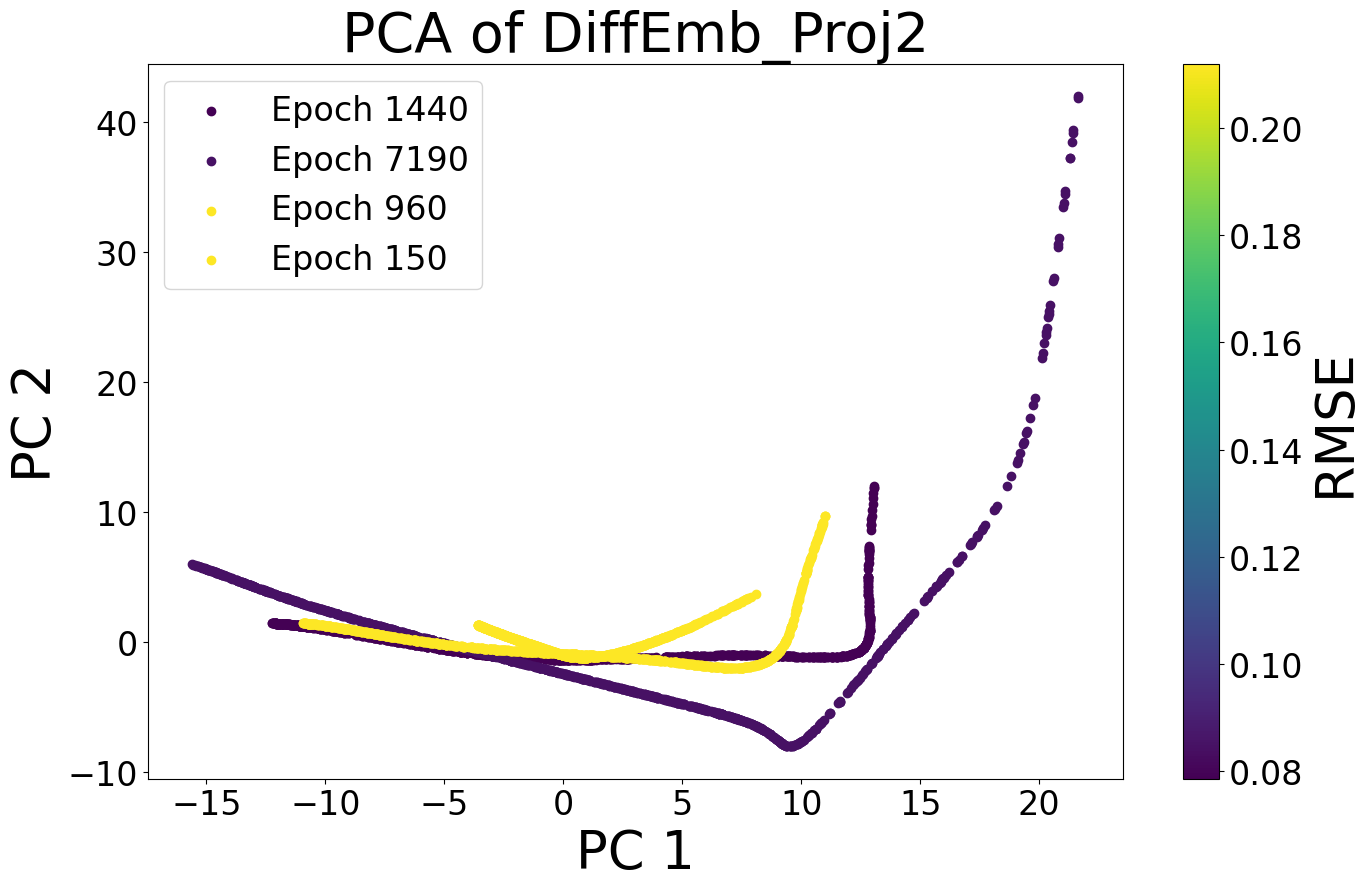

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


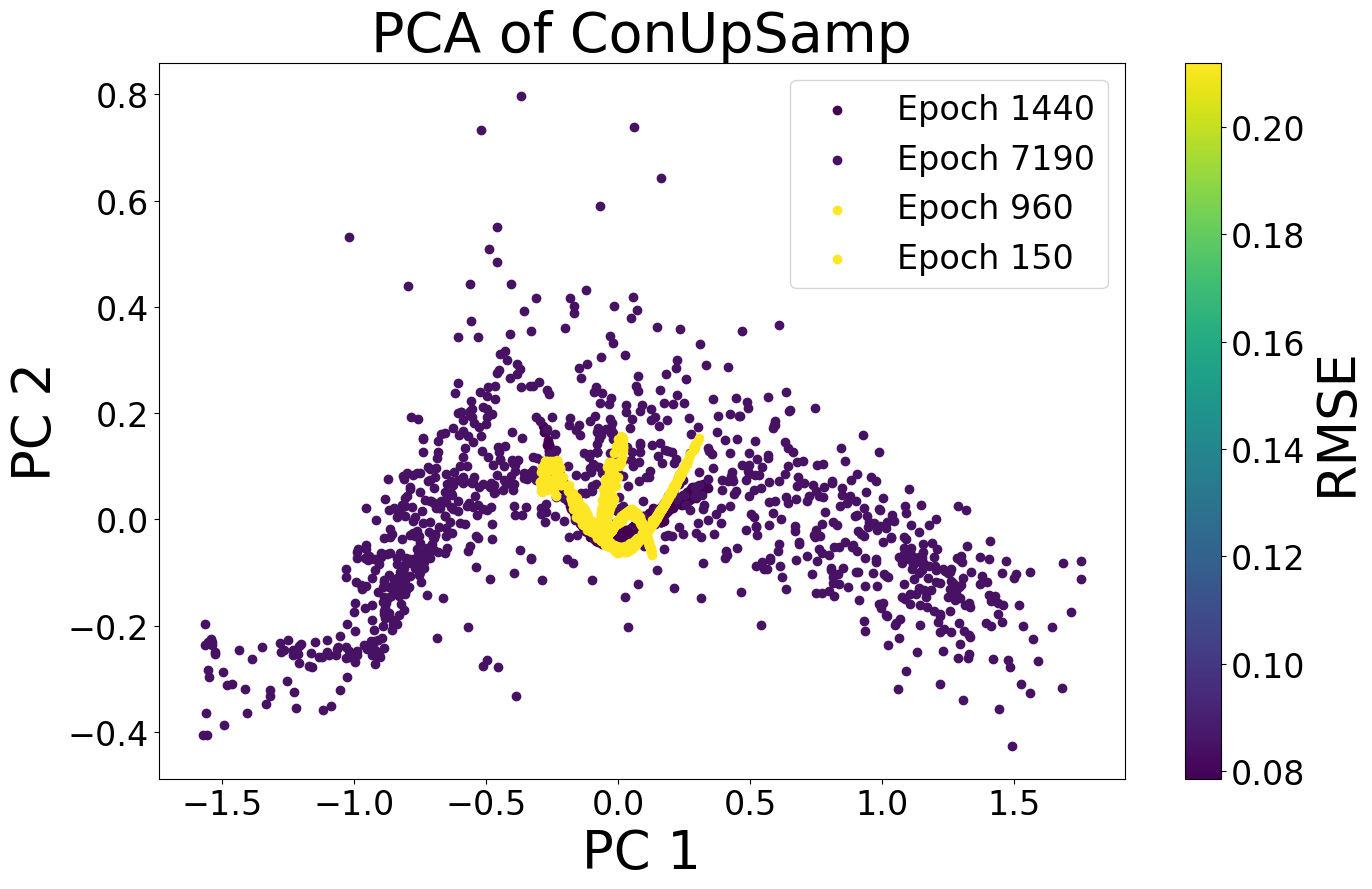

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


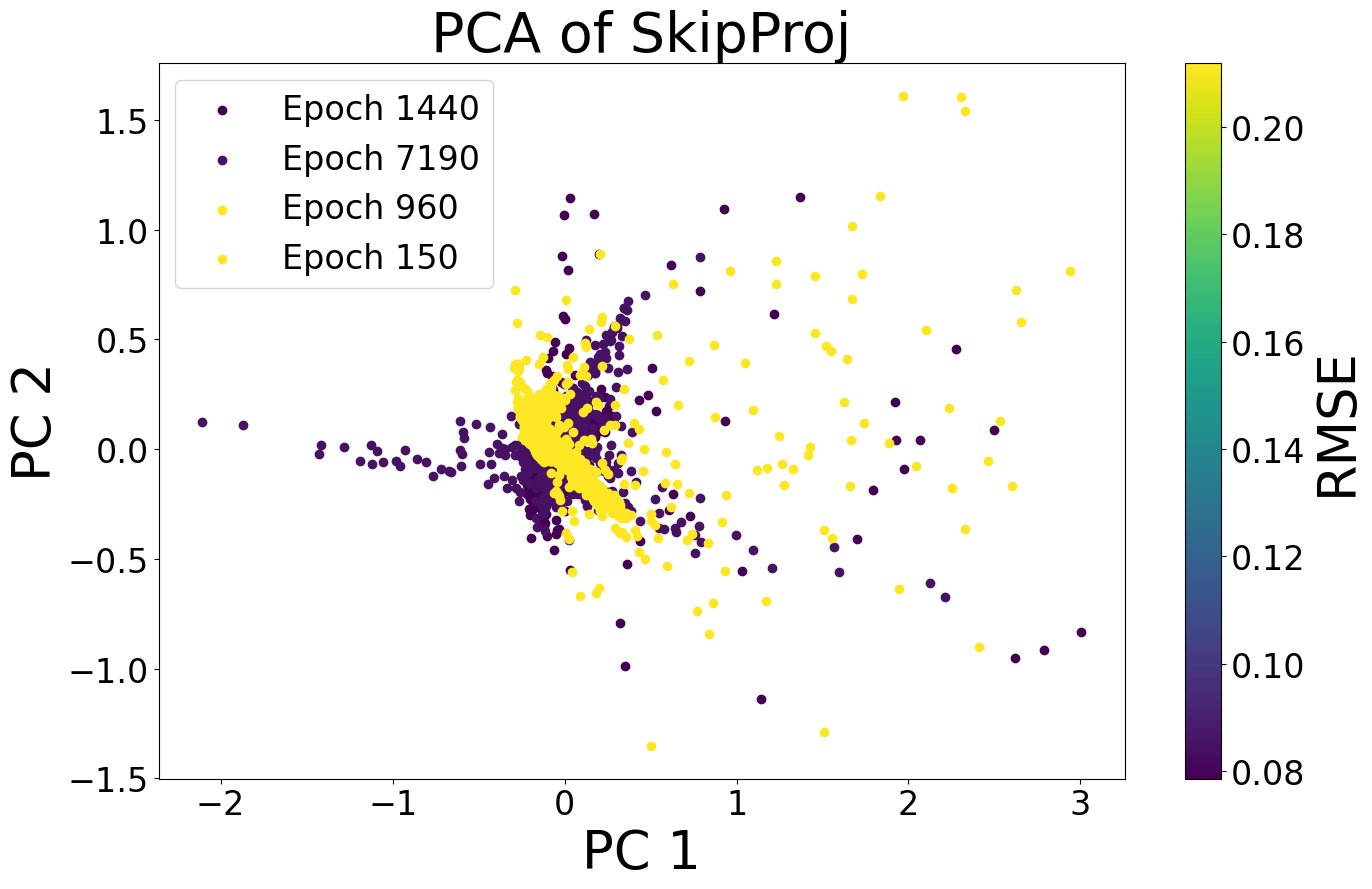

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


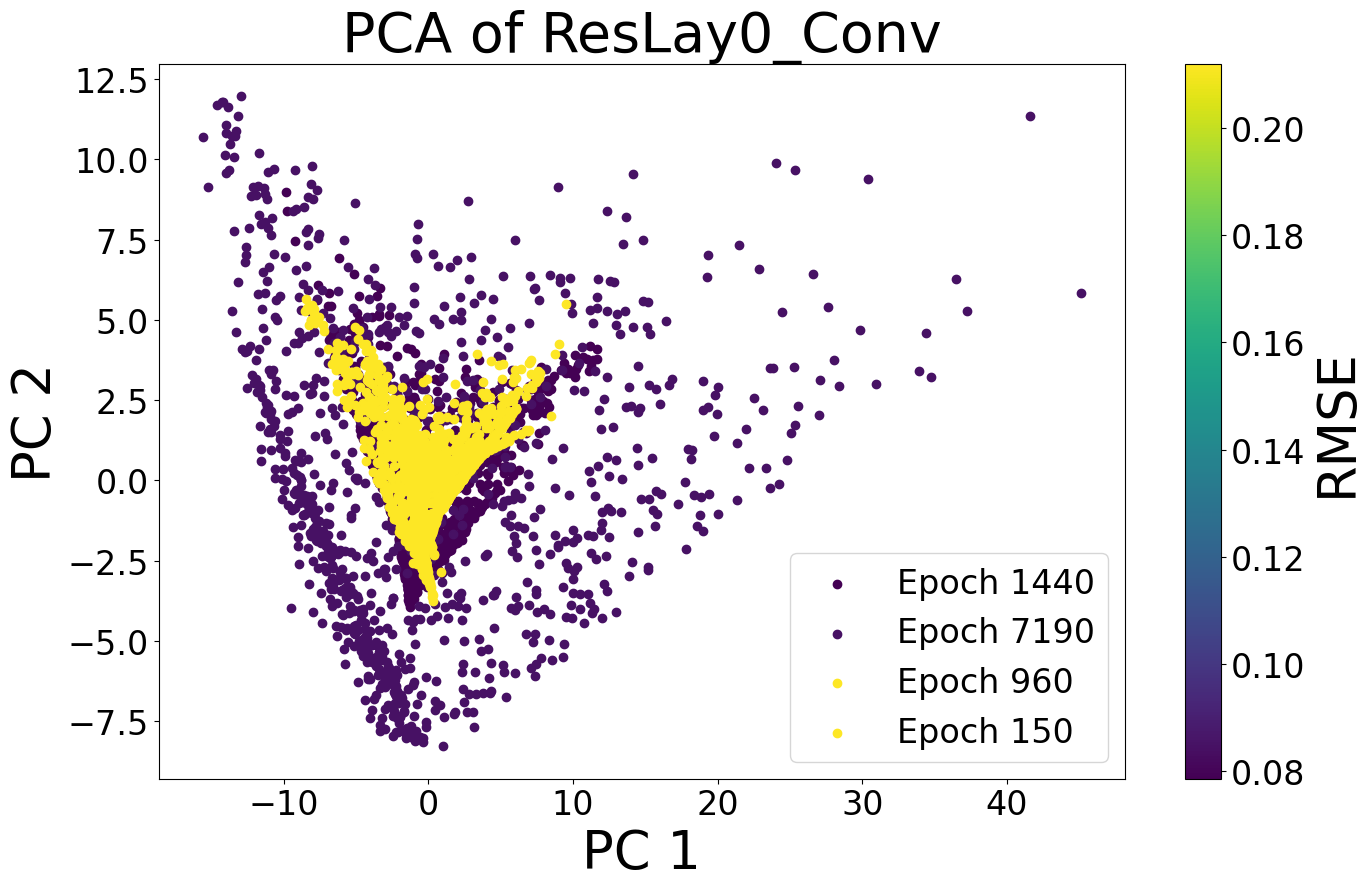

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


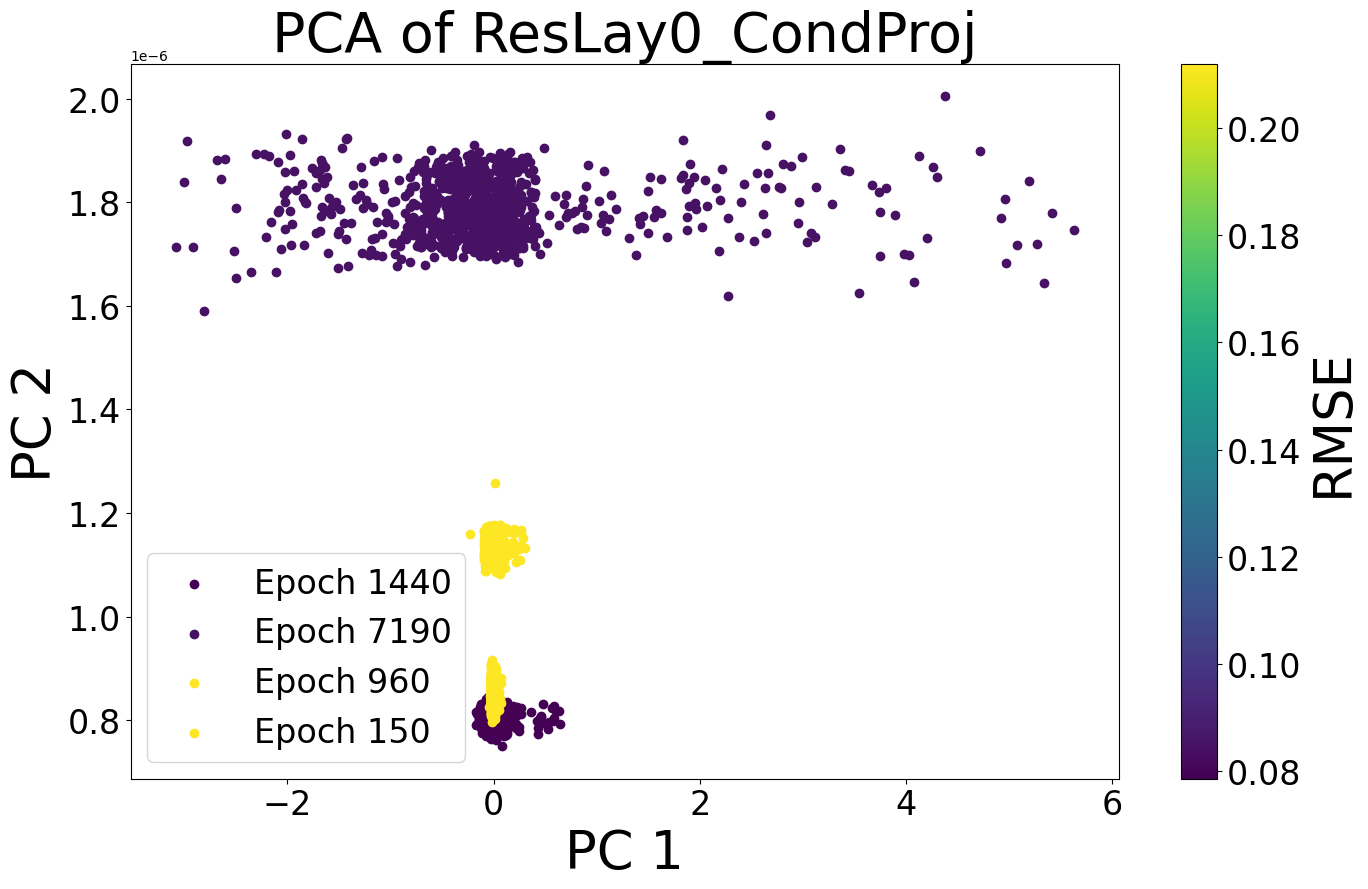

(1000, 8)
(1000, 8)
(1000, 8)
(1000, 8)


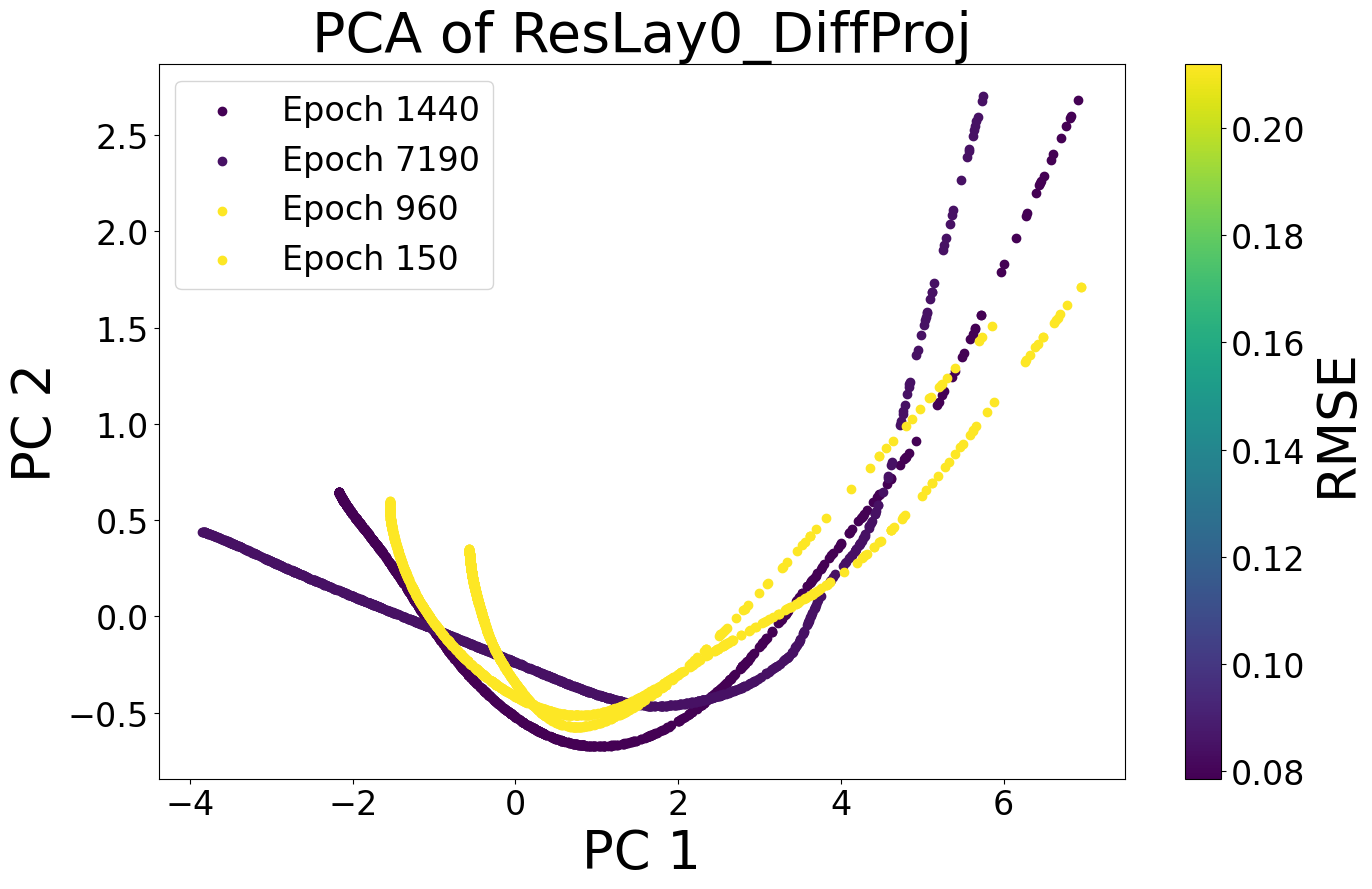

(1000, 16)
(1000, 16)
(1000, 16)
(1000, 16)


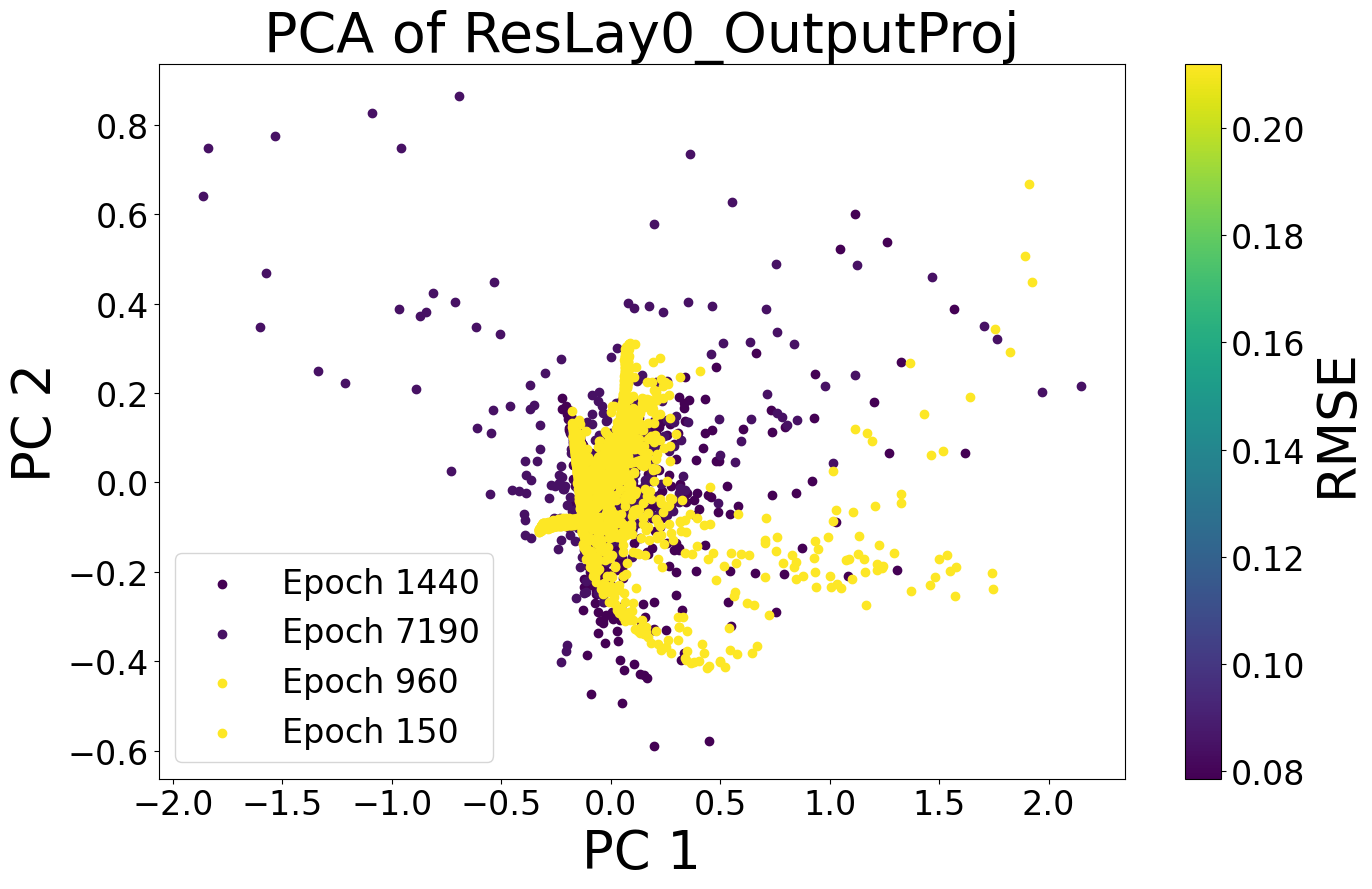

In [144]:
for hook_fn_choice in range(10):
    # Store features over different epochs
    feature_history = []
    # Iterate over the models saved at specific epochs
    for epoch in epochs:
        model_at_epoch = load_model_at_epoch(Nepoch=epoch, config=config)
        per_model_features(model=model_at_epoch, hook_fn=hook_fn, hook_fn_choice=hook_fn_choice, feature_history=feature_history, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)
    # Combine features and labels across all epochs
    feature_history = np.concatenate(feature_history, axis=0)
    if len(feature_history.shape) < 4:
        feature_history = feature_history[:, :, np.newaxis, :]
    plot_feature_evolution(feature_history=feature_history[:,:1000,:,:], epochs=epochs, rmses={k: v for k, v in rmses.items() if k in epochs},method="PCA", feature_name=feature_names[hook_fn_choice],ts_type=ts_type)

In [145]:
# Could model averaging be a solution? --> doesn't seem so
"""
import torch

def average_checkpoints(epochs, device="cpu"):

    avg_state_dict = None
    num_checkpoints = len(epochs)

    for epoch in epochs:
        checkpoint = torch.load(config.scoreNet_trained_path + "_NEp" + str(epoch))
        # If your checkpoint dictionary has a key for the model state dict, adjust here:
        state_dict = checkpoint.get("model_state_dict", checkpoint)

        # On the first checkpoint, initialize avg_state_dict with the same keys and values.
        if avg_state_dict is None:
            avg_state_dict = {k: v.float() for k, v in state_dict.items()}
        else:
            for k, v in state_dict.items():
                avg_state_dict[k] += v.float()

    # Divide by the number of checkpoints to get the average
    for k in avg_state_dict:
        avg_state_dict[k] /= num_checkpoints
    model = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters).to(device)
    # Load the averaged state dict into the model
    model.load_state_dict(avg_state_dict)
    return model

# Now you can use averaged_model for evaluation or further analysis.

averaged_model = average_checkpoints(epochs[:4], device="cpu")

SyntaxError: incomplete input (1916057029.py, line 2)

In [ ]:
from experiments.generative_modelling.RecursiveVPSDE.ParameterEstimation.PM.drifts_TSPM_LSTM_fBiPot import LSTM_1D_drifts
mu_hats = LSTM_1D_drifts(PM=averaged_model, config=config)
print(mu_hats.shape)

In [ ]:
muhats = mu_hats[:, -1, :].reshape(mu_hats.shape[0], mu_hats.shape[-1]*1).mean(axis=-1)
rmse = rmse_ignore_nans(true_drifts, muhats).astype(np.float64)
rmse

In [ ]:
per_model_features(model=model_at_epoch, hook_fn=hook_fn, hook_fn_choice=hook_fn_choice, feature_history=feature_history, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)"""